In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU(nn.Module):
    def __init__(self, H_no, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(2, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V, D):
        #V, D is shape (batch, 50000)
        
        VD = torch.zeros(V.shape[0], V.shape[1], 2).to(self.device)
        VD[:,:,0] = VD[:,:,0] + V
        VD[:,:,1] = VD[:,:,1] + D
        
        rnn_out, _ = self.rnn(VD) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        lin_out = lin_out.reshape(V.shape[0], V.shape[1])
        
        return lin_out



In [3]:
batch_size = 20
batch_length = 50000
H_no = 20
device = torch.device("cuda")

epoch_no = 200
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000].flatten()
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/V_comb_pred.npy").flatten()
V = np.load("/media/hdd01/sklee/CA1_clust4-60_noNA/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000].flatten()

#D = np.zeros((V.shape[0]))
#D[:-1] = np.diff(V)
#D = V.copy()
D_train = np.load("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s10_h20_extra_output.npz")["test"]
D_test = np.load("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s10_h20_output.npz")["test"]
D_train = torch.from_numpy(D_train).float()
D_test = torch.from_numpy(D_test).float().to(device)

#D = D.reshape(-1,batch_length)
V = V.reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)

V = torch.from_numpy(V)
#D = torch.from_numpy(D)
S = torch.from_numpy(S)


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
#D_train = D[:980].float()
#D_test = D[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float() .to(device)

train_idx = np.empty((epoch_no, 980//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0,980,batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)


In [5]:
model = AP_GRU(H_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

1461


In [6]:
score_list = []

part_time_idx = torch.arange(12000,32000)

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx_start = train_idx[i]
    batch_idx = torch.arange(batch_idx_start, batch_idx_start+5).long()
    batch_S = S_train[batch_idx].to(device)[:,part_time_idx]
    batch_V = V_train[batch_idx].to(device)[:,part_time_idx]
    batch_D = D_train[batch_idx].to(device)[:,part_time_idx]
    
    S_out = model(batch_V, batch_D)
    loss = torch.mean((S_out - batch_S)**2)
    loss.backward()
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_S_out = model(V_test[:,part_time_idx], D_test[:,part_time_idx])
        test_loss = explained_variance_score(S_test[:,part_time_idx].cpu().detach().numpy().flatten(), test_S_out.cpu().detach().numpy().flatten())
        
        score_list.append(test_loss)
        print(i, test_loss, step_time)

<ipython-input-6-c0b0dca94fca>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/9800 [00:00<?, ?it/s]

0 -0.0004165172576904297 1.098848581314087
49 0.0022510290145874023 1.0857007503509521
99 0.01575714349746704 1.0861587524414062
149 0.020569145679473877 1.088092565536499
199 0.006866812705993652 1.0872085094451904
249 0.024560093879699707 1.0917420387268066
299 0.023225843906402588 1.0857410430908203
349 0.029574036598205566 1.1134881973266602
399 0.024601519107818604 1.0958967208862305
449 0.030313432216644287 1.0682611465454102
499 0.029420316219329834 1.0828526020050049
549 0.0320667028427124 1.094118356704712
599 0.03349190950393677 1.087862253189087
649 0.03333401679992676 1.0903842449188232
699 0.037542879581451416 1.069385051727295
749 0.029420554637908936 1.0802271366119385
799 0.037671446800231934 1.0901551246643066
849 0.04221445322036743 1.0712792873382568
899 0.03487682342529297 1.0641531944274902
949 0.04405808448791504 1.0730772018432617
999 0.03815639019012451 1.1021575927734375
1049 0.04781562089920044 1.0784213542938232
1099 0.04408389329910278 1.0799720287322998
114

9299 0.04372596740722656 1.076009750366211
9349 0.049595415592193604 1.0918972492218018
9399 0.05063509941101074 1.087998628616333
9449 0.05022150278091431 1.102461814880371
9499 0.05013018846511841 1.0938260555267334
9549 0.050651729106903076 1.0937206745147705
9599 0.04878413677215576 1.0784430503845215
9649 0.050994038581848145 1.090317964553833
9699 0.04969757795333862 1.0805583000183105
9749 0.05123168230056763 0.8054718971252441
9799 0.04936635494232178 0.3817610740661621


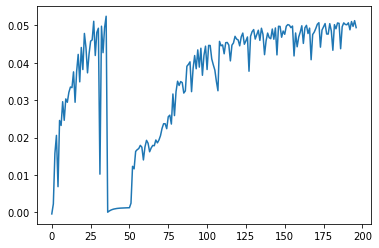

In [7]:
plt.plot(np.asarray(score_list))

(-1.0, 10.0)

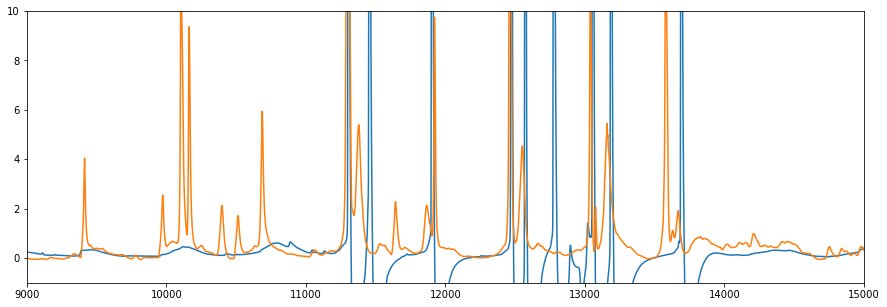

In [9]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy()[part_time_idx])
plt.plot(test_S_out[1].cpu().detach().numpy())
plt.xlim(9000,15000)
plt.ylim(-1,10)

In [10]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_AP/nona/gru_h20.pt")
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/nona/gru_h20_test.npy", test_S_out.cpu().detach().numpy())